# Research Question No. 4
What is the comparative performance of learning algorithms in long-lived bug prediction in FLOSS project? This research question aims to compare the accuracy of the long-lived bug prediction made by different classification algorithms. Here the algorithm with the best prediction capabilities is best fit in terms of balanced accuracy.

# 1. Setup environment.

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import matplotlib.pyplot as plt 
import numpy as np
import os 
import pandas as pd
import seaborn as sns 
from scipy.stats import friedmanchisquare
from scipy.stats import kruskal

# Setup Matplotlib
plt.rc('figure', figsize=(20, 20))
plt.style.use('default')
%matplotlib inline 

# Setup Seaborn
sns.set_context("paper")
sns.set_style("ticks")

pd.set_option('display.max_columns', None)

e1_metrics_path  = "datasets/20190918180550_rq3e1_eclipse_predict_long_lived_metrics.csv"
e1_tests_path    = "datasets/20190918180550_rq3e1_eclipse_predict_long_lived_tests_balanced_acc.csv"
e2_metrics_path  = "datasets/20190925194105_rq3e2_eclipse_predict_long_lived_metrics.csv"
e2_tests_path    = "datasets/20190925194105_rq3e2_eclipse_predict_long_lived_tests_balanced_acc.csv"
e3_metrics_path  = "datasets/20190925200836_rq3e3_eclipse_predict_long_lived_metrics.csv"
e3_tests_path    = "datasets/20190925200836_rq3e3_eclipse_predict_long_lived_tests_balanced_acc.csv"
e4_metrics_path  = "datasets/20190926143854_rq3e4_gcc_predict_long_lived_metrics.csv"
e4_tests_path    = "datasets/20190926143854_rq3e4_gcc_predict_long_lived_tests_balanced_acc.csv"

bug_reports_path = "datasets/20190917_eclipse_bug_report_data.csv"
bug_reports_gcc_path = "datasets/20190917_gcc_bug_report_data.csv"
print("Setup complete")

Setup complete


# 2. Load data.

In [4]:
    !echo "\nHeader of metrics file $e1_metrics_path"
    !head -n 2 $e1_metrics_path

    !echo "\nNumber of lines in the file $e1_metrics_path"
    !wc -l $e1_metrics_path

    !echo "\nHeader of metrics file $e2_metrics_path"
    !head -n 2 $e2_metrics_path

    !echo "\nNumber of lines in the file $e2_metrics_path"
    !wc -l $e2_metrics_path
    
    !echo "\nHeader of metrics file $e3_metrics_path"
    !head -n 2 $e3_metrics_path

    !echo "\nNumber of lines in the file $e3_metrics_path"
    !wc -l $e3_metrics_path
    
    !echo "\nHeader of metrics file $e4_metrics_path"
    !head -n 2 $e4_metrics_path

    !echo "\nNumber of lines in the file $e4_metrics_path"
    !wc -l $e4_metrics_path



Header of metrics file datasets/20190918180550_rq3e1_eclipse_predict_long_lived_metrics.csv
project,feature,n_term,classifier,balancing,resampling,metric,threshold,train_size,train_size_class_0,train_size_class_1,test_size,test_size_class_0,test_size_class_1,tp,fn,fp,tn,sensitivity,specificity,balanced_acc,balanced_acc_manual,precision,recall,fmeasure
eclipse,long_description,100,nn,smote,repeatedcv,Accuracy,365,12847,6665,6182,2408,2221,187,71,116,656,1565,0.379679144385027,0.704637550652859,0.542158347518943,0.542158347518943,0.097661623108666,0.379679144385027,0.155361050328228

Number of lines in the file datasets/20190918180550_rq3e1_eclipse_predict_long_lived_metrics.csv
61 datasets/20190918180550_rq3e1_eclipse_predict_long_lived_metrics.csv

Header of metrics file datasets/20190925194105_rq3e2_eclipse_predict_long_lived_metrics.csv
project,feature,n_term,classifier,balancing,resampling,metric,threshold,train_size,train_size_class_0,train_size_class_1,test_size,test_size_class_0

In [5]:
# read metrics data.
e1_metrics_data = pd.read_csv(e1_metrics_path)
rows_and_cols = e1_metrics_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {e1_metrics_path}.\n")

e2_metrics_data = pd.read_csv(e2_metrics_path)
rows_and_cols = e2_metrics_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {e2_metrics_path}.\n")

e3_metrics_data = pd.read_csv(e3_metrics_path)
rows_and_cols = e3_metrics_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {e3_metrics_path}.\n")

e4_metrics_data = pd.read_csv(e4_metrics_path)
rows_and_cols = e4_metrics_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {e4_metrics_path}.\n")

There are 60 rows and 25 columns in datasets/20190918180550_rq3e1_eclipse_predict_long_lived_metrics.csv.

There are 5 rows and 25 columns in datasets/20190925194105_rq3e2_eclipse_predict_long_lived_metrics.csv.

There are 4 rows and 25 columns in datasets/20190925200836_rq3e3_eclipse_predict_long_lived_metrics.csv.

There are 6 rows and 25 columns in datasets/20190926143854_rq3e4_gcc_predict_long_lived_metrics.csv.



# 3. First Experiment

## Experimental parameters


| Parameter                  |         Value        |
|----------------------------|:--------------------:|
| Project                    |        Eclipse       |
| Algorithms                 | KNN, NB, NN, SVM, RF |
| Metrics                    | Accuracy, Kappa, ROC |
| Features                   | Short and Long Description |
| Number of Terms            |        100       |
| Balancing                  |        Unbalance, Smote   |
| Resampling                 |        Repeated CV 5 x 2       |
| Threshold                  |        365       |








Every bug which its report have indicated that the number of days to resolve is less than or equal to **threshold fixed** was considered a **non-long lived bug** and that which the number of days to resolve is greater than this threshold was considered as a **long-live bug**. 

## 3.1 Review the data

### Best Balanced Accuracy Scores

In [6]:
e1_metrics_data.sort_values('balanced_acc', ascending=False).head(10)

,project,feature,n_term,classifier,balancing,resampling,metric,threshold,train_size,train_size_class_0,train_size_class_1,test_size,test_size_class_0,test_size_class_1,tp,fn,fp,tn,sensitivity,specificity,balanced_acc,balanced_acc_manual,precision,recall,fmeasure
0,eclipse,long_description,100,nn,smote,repeatedcv,Accuracy,365,12847,6665,6182,2408,2221,187,71,116,656,1565,0.379679,0.704638,0.542158,0.542158,0.097662,0.379679,0.155361
1,eclipse,long_description,100,nn,smote,repeatedcv,Kappa,365,12847,6665,6182,2408,2221,187,71,116,656,1565,0.379679,0.704638,0.542158,0.542158,0.097662,0.379679,0.155361
2,eclipse,short_description,100,nb,unbalanced,repeatedcv,Kappa,365,6335,5846,489,2110,1948,162,102,60,1068,880,0.629630,0.451745,0.540688,0.540688,0.087179,0.629630,0.153153
3,eclipse,short_description,100,nb,unbalanced,repeatedcv,ROC,365,6335,5846,489,2110,1948,162,102,60,1068,880,0.629630,0.451745,0.540688,0.540688,0.087179,0.629630,0.153153
4,eclipse,long_description,100,rf,smote,repeatedcv,Accuracy,365,12847,6665,6182,2408,2221,187,20,167,102,2119,0.106952,0.954075,0.530513,0.530513,0.163934,0.106952,0.129450
5,eclipse,long_description,100,rf,smote,repeatedcv,Kappa,365,12847,6665,6182,2408,2221,187,20,167,102,2119,0.106952,0.954075,0.530513,0.530513,0.163934,0.106952,0.129450
6,eclipse,long_description,100,nn,smote,repeatedcv,ROC,365,12847,6665,6182,2408,2221,187,70,117,696,1525,0.374332,0.686628,0.530480,0.530480,0.091384,0.374332,0.146905
7,eclipse,long_description,100,nb,unbalanced,repeatedcv,Kappa,365,7227,6665,562,2408,2221,187,120,67,1313,908,0.641711,0.408825,0.525268,0.525268,0.083740,0.641711,0.148148
8,eclipse,long_description,100,nb,unbalanced,repeatedcv,ROC,365,7227,6665,562,2408,2221,187,120,67,1313,908,0.641711,0.408825,0.525268,0.525268,0.083740,0.641711,0.148148
9,eclipse,long_description,100,knn,smote,repeatedcv,ROC,365,12847,6665,6182,2408,2221,187,112,75,1227,994,0.598930,0.447546,0.523238,0.523238,0.083645,0.598930,0.146789


In [7]:
e1_metrics_data[['feature', 'classifier', 'balancing', 'metric', 'sensitivity', 'specificity', 'balanced_acc']].sort_values('balanced_acc', ascending=False).head(10).to_latex('rq3e1_eclipse_metrics.tex')

### Best Sensitivity Scores

<h4 style="color:red"> New Experiment: Investigate the best classifier using sensitivity </h4>

In [8]:
e1_metrics_data.sort_values('sensitivity', ascending=False).head()

,project,feature,n_term,classifier,balancing,resampling,metric,threshold,train_size,train_size_class_0,train_size_class_1,test_size,test_size_class_0,test_size_class_1,tp,fn,fp,tn,sensitivity,specificity,balanced_acc,balanced_acc_manual,precision,recall,fmeasure
51,eclipse,short_description,100,nb,smote,repeatedcv,ROC,365,11225,5846,5379,2110,1948,162,159,3,1916,32,0.981481,0.016427,0.498954,0.498954,0.076627,0.981481,0.142155
7,eclipse,long_description,100,nb,unbalanced,repeatedcv,Kappa,365,7227,6665,562,2408,2221,187,120,67,1313,908,0.641711,0.408825,0.525268,0.525268,0.083740,0.641711,0.148148
8,eclipse,long_description,100,nb,unbalanced,repeatedcv,ROC,365,7227,6665,562,2408,2221,187,120,67,1313,908,0.641711,0.408825,0.525268,0.525268,0.083740,0.641711,0.148148
2,eclipse,short_description,100,nb,unbalanced,repeatedcv,Kappa,365,6335,5846,489,2110,1948,162,102,60,1068,880,0.629630,0.451745,0.540688,0.540688,0.087179,0.629630,0.153153
3,eclipse,short_description,100,nb,unbalanced,repeatedcv,ROC,365,6335,5846,489,2110,1948,162,102,60,1068,880,0.629630,0.451745,0.540688,0.540688,0.087179,0.629630,0.153153


#### Legenda:
* **Sensitivity:** corresponde à taxa de acerto na classe positiva. Também chamada de taxa de verdadeiros positivos: TP / ( TP + FN ).
* **Specificity:** corresponde à taxa de acerto na classe negativa: TN / ( TN + FP ).
* **Balanced Accuracy:** (Sensibilidade + Especificidade)/2.


## 3.2 Evaluation Metrics

### Sensitivity ###
Corresponde à taxa de acerto na classe positiva. Também é chamada de taxa de verdadeiros positivos: TP/(TP+FN). 

<Figure size 432x288 with 0 Axes>

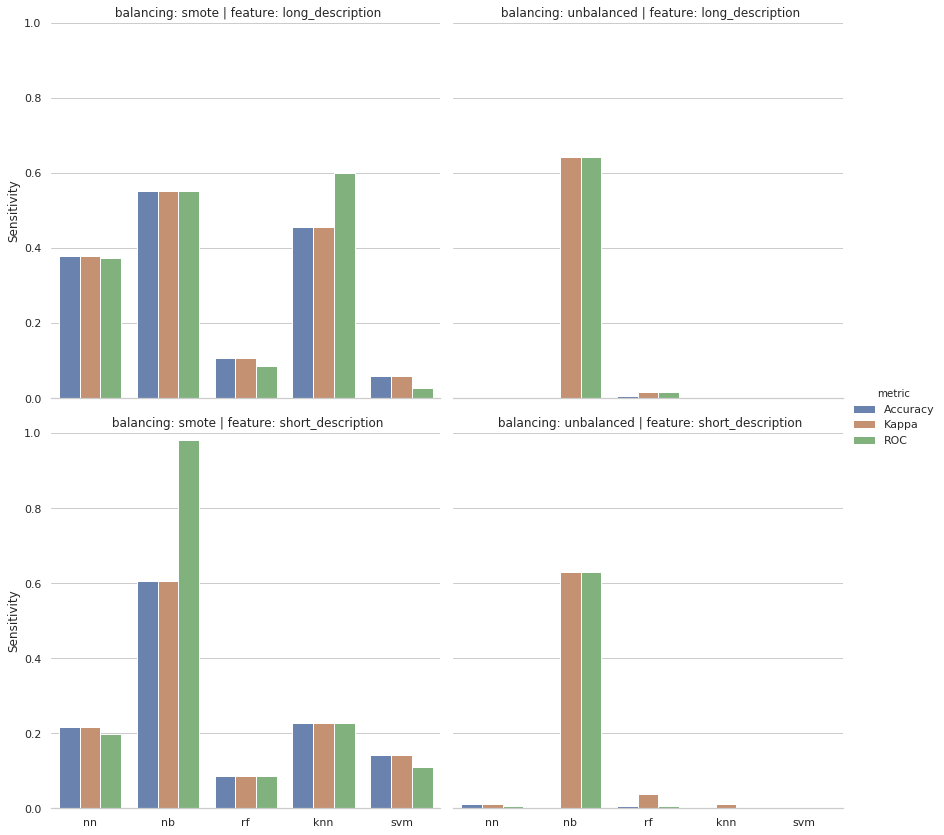

In [9]:
sns.despine(offset=5)
sns.set(style="whitegrid")
g = sns.catplot(data=e1_metrics_data
                , kind="bar"
                , x="classifier"
                , y="sensitivity"
                , hue="metric"
                , col="balancing"
                , row="feature"
                , saturation=.5
                , height=6
                , palette="muted")
(g.set_axis_labels("", "Sensitivity")
  .set_titles(" {col_var}: {col_name} | {row_var}: {row_name}")
  .set(ylim=(0, 1))
  .despine(left=True))

### Specificity ###
Corresponde à taxa de acerto na classe negativa: TN/(TN+FP). 

<Figure size 432x288 with 0 Axes>

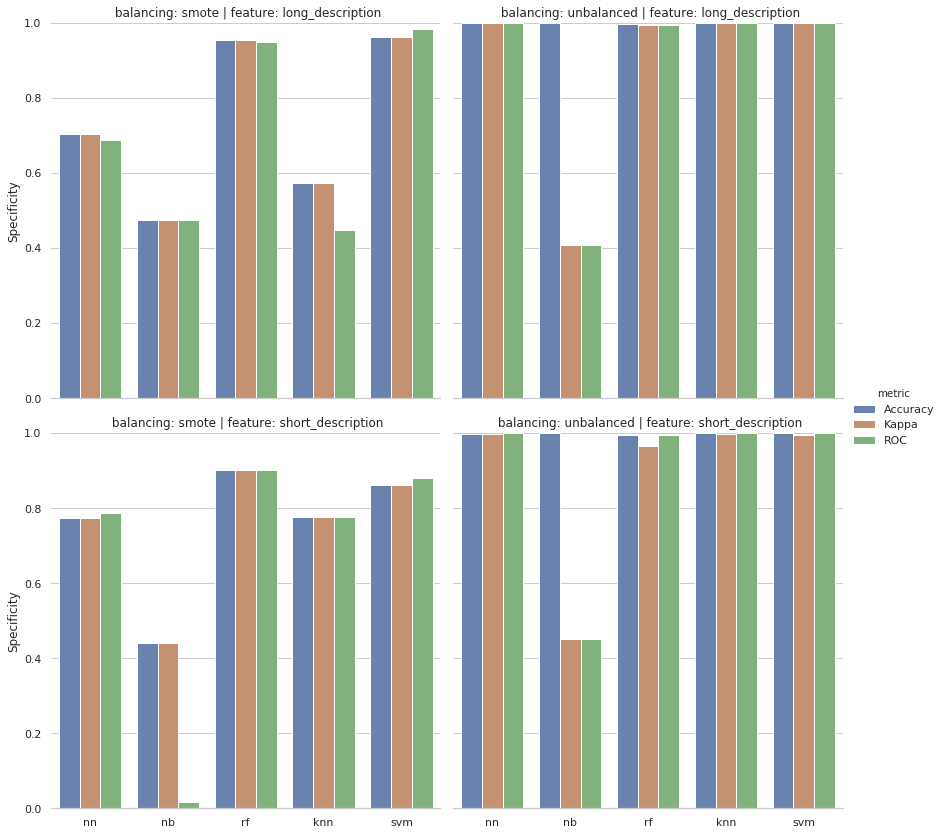

In [10]:
sns.despine(offset=5)
sns.set(style="whitegrid")
g = sns.catplot(data=e1_metrics_data
                , kind="bar"
                , x="classifier"
                , y="specificity"
                , hue="metric"
                , col="balancing"
                , row="feature"
                , saturation=.5
                , height=6
                , palette="muted")
(g.set_axis_labels("", "Specificity")
  .set_titles(" {col_var}: {col_name} | {row_var}: {row_name}")
  .set(ylim=(0, 1))
  .despine(left=True))

### Balanced Accuracy
Accurácia balanceada: (sensitivity + specificity)/2

<Figure size 432x288 with 0 Axes>

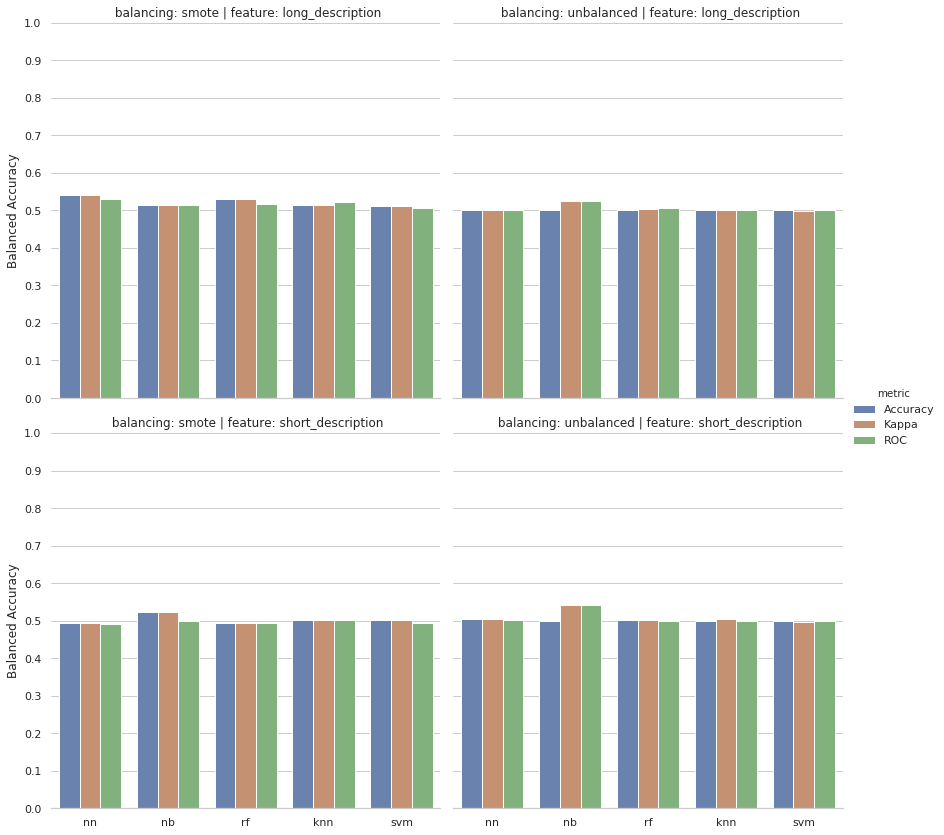

In [11]:
sns.despine(offset=5)
sns.set(style="whitegrid")
g = sns.catplot(data=e1_metrics_data
                , kind="bar"
                , x="classifier"
                , y="balanced_acc"
                , hue="metric"
                , col="balancing"
                , row="feature"
                , saturation=.5
                , height=6
                , palette="muted")
(g.set_axis_labels("", "Balanced Accuracy")
  .set_titles(" {col_var}: {col_name} | {row_var}: {row_name}")
  .set(yticks=np.arange(0, 1.1, 0.1))
  .set(ylim=(0, 1))
  .despine(left=True))

## 3.3 Statistical Test

### Balanced Accuracy 

In [12]:
# read data per classifier
knn = e1_metrics_data[e1_metrics_data['classifier'] == 'knn'].balanced_acc
nb  = e1_metrics_data[e1_metrics_data['classifier'] == 'nb'].balanced_acc
nn  = e1_metrics_data[e1_metrics_data['classifier'] == 'nn'].balanced_acc
rf  = e1_metrics_data[e1_metrics_data['classifier'] == 'rf'].balanced_acc
svm = e1_metrics_data[e1_metrics_data['classifier'] == 'svm'].balanced_acc

# compare samples with Friedman Test
stat, p = kruskal(knn, nb, nn, rf, svm)
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')


Statistics=6.604, p=0.158
Same distributions (fail to reject H0)


### Sensitivity

In [13]:
# read data per classifier
knn = e1_metrics_data[e1_metrics_data['classifier'] == 'knn'].sensitivity
nb  = e1_metrics_data[e1_metrics_data['classifier'] == 'nb'].sensitivity
nn  = e1_metrics_data[e1_metrics_data['classifier'] == 'nn'].sensitivity
rf  = e1_metrics_data[e1_metrics_data['classifier'] == 'rf'].sensitivity
svm = e1_metrics_data[e1_metrics_data['classifier'] == 'svm'].sensitivity

# compare samples with Friedman Test
stat, p = kruskal(knn, nb, nn, rf, svm)
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=16.260, p=0.003
Different distributions (reject H0)


## 3.4. Test results

In [14]:
e1_tests_data = pd.read_csv(e1_tests_path)

In [15]:
bug_reports_data = pd.read_csv(bug_reports_path)
test_e1_merged_data = pd.merge(
    bug_reports_data,
    e1_tests_data[['bug_id', 'long_lived', 'y_hat']],
    left_on='bug_id',
    right_on='bug_id',
    how='inner'
)

In [16]:
correct_predicted_bugs = test_e1_merged_data.query('long_lived == "Y" and y_hat == "Y"')
correct_predicted_bugs.head()

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,long_lived,y_hat
48,JSDT-212668,2007-12-11,General,JSDT,[hotbug] JavaScript validation error on JSPs,This is a follow-on to bug 207589:\n\nI just t...,nitind,kathy,fixed,1,resolved,4,2010-03-03,2,14,2009-02-12,429,normal,2,Y,Y
86,ASPECTJ-166347,2006-11-30,Docs,ASPECTJ,AspectJ website points to wrong version of ajd...,The AspectJ documentation http://www.eclipse.o...,aspectj-inbox,hlhawkins,fixed,1,resolved,4,2008-08-21,0,2,2008-08-21,630,normal,2,Y,Y
127,PLATFORM-56094,2004-03-25,SWT,PLATFORM,tracker resize uses screen coordinates instead...,No matter what you use in tracker's first argu...,grant_gayed,stromgt,fixed,1,resolved,4,2005-04-13,0,3,2005-04-13,384,normal,2,Y,Y
187,PLATFORM-213305,2007-12-18,SWT,PLATFORM,100% cpu usage on opening files with long lines.,Created attachment 85458\nA java source file f...,eclipse.felipe,mascha,fixed,1,resolved,4,2014-02-25,2,24,2009-02-04,414,normal,2,Y,Y
203,PLATFORM-31385,2003-02-07,SWT,PLATFORM,Redraw problems: selecting text backwards,eclipse 2.1I200302061700 linux-gtk j2sdk-1.4.1...,eclipse.felipe,nickell,fixed,1,resolved,4,2004-06-28,0,23,2004-06-28,507,normal,2,Y,Y


# 4. Second Experiment (RQ4.2)

## 4.1 Parameters


| Parameter                  |         Value        |
|----------------------------|:--------------------:|
| Project                    |        Eclipse       |
| Algorithms                 |        NN |
| Metrics                    | Accuracy |
| Features                   | Long Description |
| Number of Terms            |        100, 150, 200, 250, 300       |
| Balancing                  |        Smote   |
| Resampling                 |        Repeated CV 5 x 2       |
| Threshold                  |        365       |








Every bug which its report have indicated that the number of days to resolve is less than or equal to **threshold fixed** was considered a **non-long lived bug** and that which the number of days to resolve is greater than this threshold was considered as a **long-live bug**. 

## 4.2 Review Data

In [17]:
e2_metrics_data.sort_values('balanced_acc', ascending=False).head()

,project,feature,n_term,classifier,balancing,resampling,metric,threshold,train_size,train_size_class_0,train_size_class_1,test_size,test_size_class_0,test_size_class_1,tp,fp,tn,fn,sensitivity,specificity,balanced_acc,balanced_acc_manual,precision,recall,fmeasure
0,eclipse,long_description,100,nn,smote,repeatedcv,Accuracy,365,12847,6665,6182,2408,2221,187,71,656,1565,116,0.379679,0.704638,0.542158,0.542158,0.097662,0.379679,0.155361
1,eclipse,long_description,150,nn,smote,repeatedcv,Accuracy,365,12926,6700,6226,2421,2233,188,63,568,1665,125,0.335106,0.745634,0.540370,0.540370,0.099842,0.335106,0.153846
4,eclipse,long_description,300,nn,smote,repeatedcv,Accuracy,365,12966,6729,6237,2432,2243,189,45,411,1832,144,0.238095,0.816763,0.527429,0.527429,0.098684,0.238095,0.139535
2,eclipse,long_description,200,nn,smote,repeatedcv,Accuracy,365,12954,6717,6237,2426,2238,188,49,475,1763,139,0.260638,0.787757,0.524198,0.524198,0.093511,0.260638,0.137640
3,eclipse,long_description,250,nn,smote,repeatedcv,Accuracy,365,12963,6726,6237,2429,2241,188,44,439,1802,144,0.234043,0.804105,0.519074,0.519074,0.091097,0.234043,0.131148


## 4.3 Evaluation Metrics

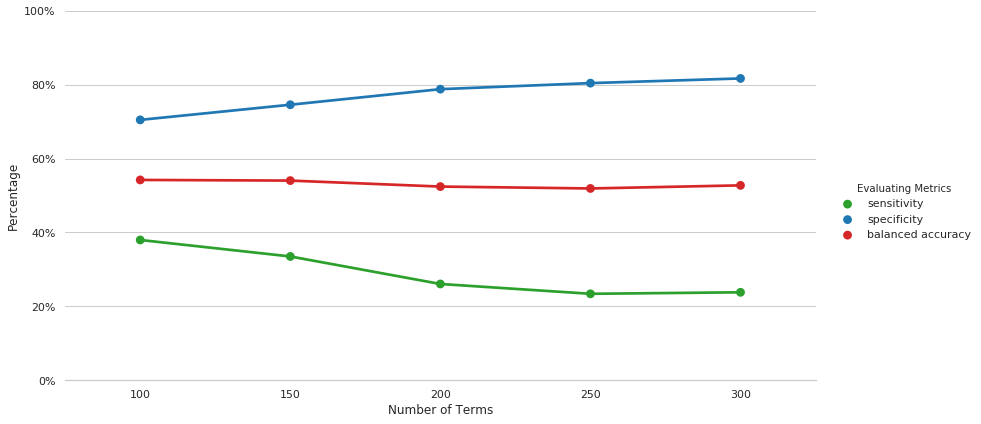

In [18]:
from  matplotlib.ticker import PercentFormatter
sns.set_context("paper")
sns.set(style="whitegrid", font_scale=1.0)
e2_metrics_data_melted = e2_metrics_data[['n_term', 'sensitivity', 'specificity', 'balanced_acc']].melt(id_vars=['n_term']) 
g = sns.catplot(data=e2_metrics_data_melted
                , kind="point"
                , x="n_term"
                , y="value"
                , hue="variable"
                , saturation=.5
                , height=6
                #, size=5
                , aspect=2
                , palette=["tab:green", "tab:blue", "tab:red"]
                , legend_out=True)
(g.set_axis_labels("Number of Terms", "Percentage")
  .set_titles(" Balanced Accuracy: Neural Network")
  .set(ylim=(0, 1))
  .despine(left=True))

# Format y scale in percentage format. 
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))

# Change and ajust legend. 
box = g.ax.get_position()
g.ax.set_position([box.x0, box.y0, box.width * 0.95, box.height]) # resize position
g._legend.set_title("Evaluating Metrics")
for t, l in zip(g._legend.texts, ['sensitivity', 'specificity', 'balanced accuracy']): t.set_text(l)

plt.show(g)

## 4.4 Test Results

In [19]:
e2_tests_data = pd.read_csv(e2_tests_path)
bug_reports_data = pd.read_csv(bug_reports_path)
test_e2_merged_data = pd.merge(
    bug_reports_data,
    e2_tests_data[['bug_id', 'long_lived', 'y_hat']],
    left_on='bug_id',
    right_on='bug_id',
    how='inner'
)
correct_predicted_bugs = test_e2_merged_data.query('long_lived == "Y" and y_hat == "Y"')
correct_predicted_bugs.head()

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,long_lived,y_hat
48,JSDT-212668,2007-12-11,General,JSDT,[hotbug] JavaScript validation error on JSPs,This is a follow-on to bug 207589:\n\nI just t...,nitind,kathy,fixed,1,resolved,4,2010-03-03,2,14,2009-02-12,429,normal,2,Y,Y
86,ASPECTJ-166347,2006-11-30,Docs,ASPECTJ,AspectJ website points to wrong version of ajd...,The AspectJ documentation http://www.eclipse.o...,aspectj-inbox,hlhawkins,fixed,1,resolved,4,2008-08-21,0,2,2008-08-21,630,normal,2,Y,Y
127,PLATFORM-56094,2004-03-25,SWT,PLATFORM,tracker resize uses screen coordinates instead...,No matter what you use in tracker's first argu...,grant_gayed,stromgt,fixed,1,resolved,4,2005-04-13,0,3,2005-04-13,384,normal,2,Y,Y
187,PLATFORM-213305,2007-12-18,SWT,PLATFORM,100% cpu usage on opening files with long lines.,Created attachment 85458\nA java source file f...,eclipse.felipe,mascha,fixed,1,resolved,4,2014-02-25,2,24,2009-02-04,414,normal,2,Y,Y
203,PLATFORM-31385,2003-02-07,SWT,PLATFORM,Redraw problems: selecting text backwards,eclipse 2.1I200302061700 linux-gtk j2sdk-1.4.1...,eclipse.felipe,nickell,fixed,1,resolved,4,2004-06-28,0,23,2004-06-28,507,normal,2,Y,Y


# 5. Third Experiment (RQ4.3)

## 5.1 Parameters

| Parameter                  |         Value        |
|----------------------------|:--------------------:|
| Project                    |        Eclipse       |
| Algorithms                 |        NN |
| Metrics                    | Accuracy |
| Features                   | Long Description |
| Number of Terms            |        100       |
| Balancing                  |        Smote   |
| Resampling                 |        Repeated CV 5 x 2       |
| Threshold                  |        1, 8, 63, 365       |








Every bug which its report have indicated that the number of days to resolve is less than or equal to **threshold fixed** was considered a **non-long lived bug** and that which the number of days to resolve is greater than this threshold was considered as a **long-live bug**. 

## 5.2 Review Data

In [20]:
e3_metrics_data.sort_values('balanced_acc', ascending=False).head()

,project,feature,n_term,classifier,balancing,resampling,metric,threshold,train_size,train_size_class_0,train_size_class_1,test_size,test_size_class_0,test_size_class_1,tp,fp,tn,fn,sensitivity,specificity,balanced_acc,balanced_acc_manual,precision,recall,fmeasure
0,eclipse,long_description,100,nn,smote,repeatedcv,Accuracy,1,9401,4348,5053,2408,724,1684,1183,439,285,501,0.702494,0.393646,0.548070,0.548070,0.729346,0.702494,0.715668
3,eclipse,long_description,100,nn,smote,repeatedcv,Accuracy,365,12847,6665,6182,2408,2221,187,71,656,1565,116,0.379679,0.704638,0.542158,0.542158,0.097662,0.379679,0.155361
1,eclipse,long_description,100,nn,smote,repeatedcv,Accuracy,8,7227,3612,3615,2408,1203,1205,658,594,609,547,0.546058,0.506234,0.526146,0.526146,0.525559,0.546058,0.535613
2,eclipse,long_description,100,nn,smote,repeatedcv,Accuracy,63,9039,5415,3624,2408,1805,603,103,269,1536,500,0.170813,0.850970,0.510891,0.510891,0.276882,0.170813,0.211282


## 5.3 Evaluation Metrics

<Figure size 432x288 with 0 Axes>

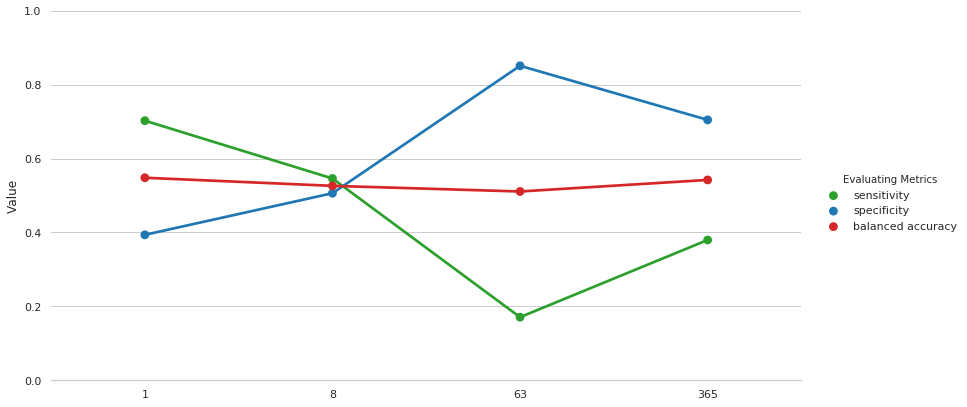

In [22]:
sns.despine(offset=5)
sns.set(style="whitegrid")
e3_metrics_data_melted = e3_metrics_data[['threshold', 'sensitivity', 'specificity', 'balanced_acc']].melt(id_vars=['threshold']) 
g = sns.catplot(data=e3_metrics_data_melted
                , kind="point"
                , x="threshold"
                , y="value"
                , hue="variable"
                #, col="balancing"
                #, row="feature"
                , saturation=.5
                , height=6
                , aspect=2
                , palette=["tab:green", "tab:blue", "tab:red"])
(g.set_axis_labels("", "Value")
  .set_titles(" Sensitivity: Neural Network")
  .set(ylim=(0, 1))
  .despine(left=True))

# Change and ajust legend. 
box = g.ax.get_position()
g.ax.set_position([box.x0, box.y0, box.width * 0.95, box.height]) # resize position
g._legend.set_title("Evaluating Metrics")
for t, l in zip(g._legend.texts, ['sensitivity', 'specificity', 'balanced accuracy']): t.set_text(l)

plt.show(g)

## 5.4 Tests Results

In [23]:
e3_tests_data = pd.read_csv(e3_tests_path)
bug_reports_data = pd.read_csv(bug_reports_path)
test_e3_merged_data = pd.merge(
    bug_reports_data,
    e2_tests_data[['bug_id', 'long_lived', 'y_hat']],
    left_on='bug_id',
    right_on='bug_id',
    how='inner'
)
correct_predicted_bugs = test_e3_merged_data.query('long_lived == "Y" and y_hat == "Y"')
correct_predicted_bugs.head()

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,long_lived,y_hat
48,JSDT-212668,2007-12-11,General,JSDT,[hotbug] JavaScript validation error on JSPs,This is a follow-on to bug 207589:\n\nI just t...,nitind,kathy,fixed,1,resolved,4,2010-03-03,2,14,2009-02-12,429,normal,2,Y,Y
86,ASPECTJ-166347,2006-11-30,Docs,ASPECTJ,AspectJ website points to wrong version of ajd...,The AspectJ documentation http://www.eclipse.o...,aspectj-inbox,hlhawkins,fixed,1,resolved,4,2008-08-21,0,2,2008-08-21,630,normal,2,Y,Y
127,PLATFORM-56094,2004-03-25,SWT,PLATFORM,tracker resize uses screen coordinates instead...,No matter what you use in tracker's first argu...,grant_gayed,stromgt,fixed,1,resolved,4,2005-04-13,0,3,2005-04-13,384,normal,2,Y,Y
187,PLATFORM-213305,2007-12-18,SWT,PLATFORM,100% cpu usage on opening files with long lines.,Created attachment 85458\nA java source file f...,eclipse.felipe,mascha,fixed,1,resolved,4,2014-02-25,2,24,2009-02-04,414,normal,2,Y,Y
203,PLATFORM-31385,2003-02-07,SWT,PLATFORM,Redraw problems: selecting text backwards,eclipse 2.1I200302061700 linux-gtk j2sdk-1.4.1...,eclipse.felipe,nickell,fixed,1,resolved,4,2004-06-28,0,23,2004-06-28,507,normal,2,Y,Y


# 6. Fourth Experiment

## 6.1 Parameters

| Parameter                  |         Value        |
|----------------------------|:--------------------:|
| Project                    |        Eclipse, Freedesktop, Gcc, Gnome, Mozilla, WineHQ       |
| Algorithms                 |        NN |
| Metrics                    | Accuracy |
| Features                   | Long Description |
| Number of Terms            |        100       |
| Balancing                  |        Smote   |
| Resampling                 |        Repeated CV 5 x 2       |
| Threshold                  |        365       |








Every bug which its report have indicated that the number of days to resolve is less than or equal to **threshold fixed** was considered a **non-long lived bug** and that which the number of days to resolve is greater than this threshold was considered as a **long-live bug**.

## 6.2 Review Data

In [24]:
e4_metrics_data.sort_values('balanced_acc', ascending=False).head()

,project,feature,n_term,classifier,balancing,resampling,metric,threshold,train_size,train_size_class_0,train_size_class_1,test_size,test_size_class_0,test_size_class_1,tp,fp,tn,fn,sensitivity,specificity,balanced_acc,balanced_acc_manual,precision,recall,fmeasure
2,gcc,long_description,100,nn,smote,repeatedcv,Accuracy,365,9616,5268,4348,2480,1756,724,380,192,1564,344,0.524862,0.890661,0.707761,0.707761,0.664336,0.524862,0.586420
4,mozilla,long_description,100,nn,smote,repeatedcv,Accuracy,365,11170,5918,5252,2409,1972,437,248,652,1320,189,0.567506,0.669371,0.618438,0.618438,0.275556,0.567506,0.370980
3,gnome,long_description,100,nn,smote,repeatedcv,Accuracy,365,9287,5017,4270,1956,1672,284,133,466,1206,151,0.468310,0.721292,0.594801,0.594801,0.222037,0.468310,0.301246
5,winehq,long_description,100,nn,smote,repeatedcv,Accuracy,365,4527,2688,1839,1507,895,612,181,149,746,431,0.295752,0.833520,0.564636,0.564636,0.548485,0.295752,0.384289
1,freedesktop,long_description,100,nn,smote,repeatedcv,Accuracy,365,9606,4908,4698,1895,1635,260,128,627,1008,132,0.492308,0.616514,0.554411,0.554411,0.169536,0.492308,0.252217


## 6.3 Evaluation Metrics

<Figure size 432x288 with 0 Axes>

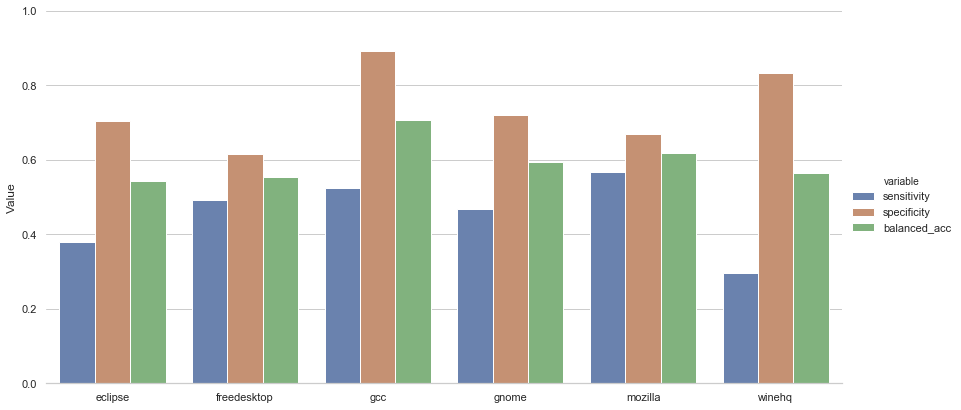

In [28]:
sns.despine(offset=5)
sns.set(style="whitegrid")
e4_metrics_data_melted = e4_metrics_data[['project', 'sensitivity', 'specificity', 'balanced_acc']].melt(id_vars=['project']) 
g = sns.catplot(data=e4_metrics_data_melted
                , kind="bar"
                , x="project"
                , y="value"
                , hue="variable"
                , saturation=.5
                , height=6
                , aspect=2
                , palette="muted")
(g.set_axis_labels("", "Value")
  .set_titles(" GCC: Neural Network Performance")
  .set(ylim=(0,1))
  .despine(left=True))

## 6.4 Tests Results

In [29]:
e4_tests_data = pd.read_csv(e4_tests_path)
bug_reports_data = pd.read_csv(bug_reports_gcc_path)
test_e4_merged_data = pd.merge(
    bug_reports_data,
    e4_tests_data[['bug_id', 'long_lived', 'y_hat']],
    left_on='bug_id',
    right_on='bug_id',
    how='inner'
)
correct_predicted_bugs = test_e4_merged_data.query('long_lived == "Y" and y_hat == "Y"')
correct_predicted_bugs.head()

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,long_lived,y_hat
4,GCC-560,2000-09-21,target,GCC,[Solaris 8 x86] static code segfaults before main,If you compile static code any code with gcc o...,unassigned,rami.lehti,fixed,1,resolved,4,2003-07-25,0,2,2003-07-25,1037,normal,2,Y,Y
12,GCC-2434,2001-03-30,target,GCC,Compilation with large file support (solaris &...,When compiling C++ programs using the flags fo...,unassigned,pnobili,fixed,1,resolved,4,2003-07-25,0,5,2003-07-25,847,normal,2,Y,Y
30,GCC-4459,2001-10-03,c++,GCC,g++ 3.0.1 resolves to wrong const overload whe...,When access adjustment is used in the body of ...,unassigned,yoder,fixed,1,resolved,4,2003-07-25,0,3,2003-07-25,660,normal,2,Y,Y
34,GCC-6258,2002-04-11,rtl-optimization,GCC,floor() may return incorrect value when optimized,Under some circumstances the GCC optimizations...,unassigned,karl,fixed,1,resolved,4,2003-07-25,0,3,2003-07-25,470,normal,2,Y,Y
35,GCC-7290,2002-07-12,java,GCC,Inherited method not found when extending abst...,\tIf there is an interface I with one method f...,unassigned,jmr,fixed,1,resolved,4,2003-08-19,0,5,2003-08-19,403,normal,2,Y,Y


In [ ]:
e4_metrics_data_melted.sort_values(['variable', '')
